## Background

---

The previous notebook provides detailed guide on the exploration and manipulation of data, whereas this one will be centered around the modeling process itself. Understanding the data is important for analytics, and we recommend you to read the first notebook prior to diving into modeling in order to gain a better grasp of our big and messy data. The datasets that we are using contain sales records for a retailers with 45 stores, each containing several departments. They already included in the repository where this Jupyter notebook is located (see the "Data" folder), but you can also find them on [this Kaggle page](https://www.kaggle.com/manjeetsingh/retaildataset?select=sales+data-set.csv). 

Let's first import the libraries and datasets:

In [1]:
import pandas as pd
import numpy as np
import datetime
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
# Prophet is a forecasting package developed by Facebook
from fbprophet import Prophet
# ipywidgets are used to make interactive contents in Jupyter notebooks
from ipywidgets import interact

# There are multiple SettingWithCopyWarnings in this notebook
# which we will choose to ignore
# Read more here:
# https://www.dataquest.io/blog/settingwithcopywarning/
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
import warnings
warnings.filterwarnings('ignore')

# import data
df_sales = pd.read_csv('Data/sales.csv')
df_features = pd.read_csv('Data/features.csv')
df_stores = pd.read_csv('Data/stores.csv')

# converting the date column (initally stored as strings) to dates
df_sales['Date'] = pd.to_datetime(df_sales['Date'], format='%d/%m/%Y')
df_features['Date'] = pd.to_datetime(df_features['Date'], format='%d/%m/%Y')

# converting categorical-numeric columns to categories, which increases run speed
df_sales['Store'] = df_sales['Store'].astype('category')
df_sales['Dept'] = df_sales['Dept'].astype('category')
df_features['Store'] = df_features['Store'].astype('category')
df_stores['Store'] = df_stores['Store'].astype('category')
df_stores['Type'] = df_stores['Type'].astype('category')

## Modeling

---

In this notebook, we will be using the `Prophet` forecasting package developed by Facebook. However, there are many other methods of forecasting, such as ARIMA models, ETS models, a combination of explanatory models (linear regression) and time series models, as well as several machine learning models. After reading this notebook, we encourage you to experiment with different forecasting packages in Python (or R) so that you can find the best fit for your data.

### STL Decomposition

Time series data can usually be described with Trend, Cycle, and Seasonality. The book, "Forecasting: Principles and Practice", does a great job defining these three components in [Chapter 2.3](https://otexts.com/fpp2/tspatterns.html). Often times, identifying these components in our data (and understanding our data in general) can help us select the most appropriate model(s). Just like forecasting, there are many different ways to decompose time series as well. STL decomposition (short for Seasonal and Trend decomposition using Loess) is helpful in our case because we have weekly data, while a lot of other decomposition methods are only applicable to monthly or quarterly data. Here, we utilize `ipywidgets` again ((please read its [documentation](https://ipywidgets.readthedocs.io/en/latest/) for more information or tutorials), together with the `STL` function from `statsmodels`, to inspect the different trends and seasonalities across stores and departments:

In [2]:
def stl_viz(store_num, dept_num):
    try:
        # Subsetting data according to store and department number
        sales_temp = df_sales[(df_sales.Store==store_num)&(df_sales.Dept==dept_num)]
        # Transform dataframe into time series
        sales_temp_ts = sales_temp.set_index('Date')['Weekly_Sales']
        # Decompose the data
        stl_temp = STL(sales_temp_ts).fit()
        # Set up plot
        plt.rc('figure',figsize=(12,8))
        plot_temp = stl_temp.plot()
        plt.show()
        return 
    except:
        # Error message for when store-department combination doesn't exist
        print("ERROR: There is no Department {} in Store {}".format(store_num, dept_num))
        return

display(interact(stl_viz, store_num={n:n for n in range(1,46)}, dept_num={n:n for n in range(1,100)}))

interactive(children=(Dropdown(description='store_num', options={1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: …

<function __main__.stl_viz(store_num, dept_num)>

### Prophet

Prophet is a package developed by Facebook. It is fast and fully automatic, which might not always be the best but surely is convenient, and it is compatible with weekly data, which is one of the biggest reasons we are using it in this case since a lot of other models, such as ARIMA and ETS models, only takes in integer seasonalities (12 for example) whereas the number of weeks in a year is usually not an integer (52.14). Prophet also allows users to specify holidays in the model, so that unusual observations caused by holidays can also be modeled. Let's start by building a model for Store 1 Department 1. 

First we will subset the `sales` dataframe for rows where the `Store` and the `Dept` column both are equal to 1:

In [3]:
sales_s1d1_df = df_sales[(df_sales.Store==1)&(df_sales.Dept==1)]

# Taking the log of `Weekly_Sales` so that it is less right skewed
sales_s1d1_df.loc[:,'Log_Weekly_Sales'] = np.log(sales_s1d1_df.loc[:,'Weekly_Sales'])

sales_s1d1_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Log_Weekly_Sales
0,1,1,2010-02-05,24924.50,False,10.123607
1,1,1,2010-02-12,46039.49,True,10.737255
2,1,1,2010-02-19,41595.55,False,10.635748
3,1,1,2010-02-26,19403.54,False,9.873211
4,1,1,2010-03-05,21827.90,False,9.990944


#### Train/Test Split

Just like a lot of machine learning models, we want to split our data into training and testing sets (commonly 80% and 20%) before we build our models, so that we can evaluate the performance of these models. In our case, even though we do not have a lot of data to work with (2 years of data with yearly seasonality), we still would want to have at least an entire year of data in our testing set so that we could evaluate the performance of our model across seasons. From the first notebook, we know that the last date in our dataset is '2012-10-26', so we will set the cut off line exactly a year before that date (note that you must use a date that exists in the data to keep the weekly intervals consistent). Prophet is very particular about the data that it uses: the date column has to be named `ds` while the dependent variable should be named `y`; we will format our dataframe accordingly.

In [21]:
# Define threshold date and creating a threashold filter
threshold_date = pd.to_datetime('2011-10-28')
threshold = sales_s1d1_df.Date <= threshold_date

# Splitting the original dataframe into training and testing sets for residual diagnosis later
sales_s1d1_df_train = sales_s1d1_df[threshold]
sales_s1d1_df_test = sales_s1d1_df[~threshold]


sales_s1d1_train = (sales_s1d1_df_train[['Date', 'Log_Weekly_Sales']]
                    .rename(columns={'Date':'ds', 'Log_Weekly_Sales': 'y'}))
sales_s1d1_test = (sales_s1d1_df_test[['Date', 'Log_Weekly_Sales']]
                   .rename(columns={'Date':'ds', 'Log_Weekly_Sales': 'y'}))

display(sales_s1d1_train.head())
print('ATTENTION: Training set has {} rows'.format(sales_s1d1_train.shape[0]))
display(sales_s1d1_test.head())
print('ATTENTION: Testing set has {} rows'.format(sales_s1d1_test.shape[0]))

,ds,y
0,2010-02-05,10.123607
1,2010-02-12,10.737255
2,2010-02-19,10.635748
3,2010-02-26,9.873211
4,2010-03-05,9.990944


ATTENTION: Training set has 91 rows


,ds,y
91,2011-11-04,10.593782
92,2011-11-11,9.835719
93,2011-11-18,9.854857
94,2011-11-25,9.948043
95,2011-12-02,10.138302


ATTENTION: Testing set has 52 rows


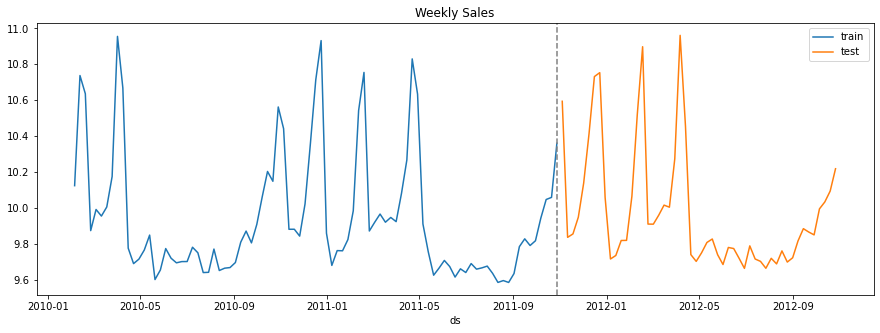

In [5]:
# Visualize train/test split
plt.rc('figure',figsize=(15,5))
fig, ax = plt.subplots()

sns.lineplot(x='ds', y='y', label='train', data=sales_s1d1_train, ax=ax)
sns.lineplot(x='ds', y='y', label='test', data=sales_s1d1_test, ax=ax)

# A vertical gray dashed line seperating the training and testing sets
ax.axvline(threshold_date, color='grey', linestyle='--')

ax.legend(loc='upper right')
ax.set(title='Weekly Sales', ylabel='');

#### Holidays

To model holidays in Prophet, we have to create a similar time series dataframe, with the name of the holidays as column `holiday` and the date again as `ds`. Here we create this dataframe accordingly:

In [6]:
# Subsetting data where the `IsHoliday` column indicates that the observation is a holiday
holidays_s1d1_df = sales_s1d1_df[sales_s1d1_df.IsHoliday==True]
# Create new dataframe with only `ds` and `holiday` columns
holidays_s1d1 = pd.DataFrame({'ds':holidays_s1d1_df['Date'], 'holiday':'holiday'})
display(holidays_s1d1.head())

,ds,holiday
1,2010-02-12,holiday
31,2010-09-10,holiday
42,2010-11-26,holiday
47,2010-12-31,holiday
53,2011-02-11,holiday


#### Fitting

Now we have our datasets ready, we can finally fit the model. One of the parameters of the model is called `mcmc_samples`, which sepcifies the number of samples to create using the [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) method; this parameter has an impact on the confidence interval of our model, but for the sake of this project, we will not get into further details.

In [7]:
model = Prophet(yearly_seasonality=True, 
                weekly_seasonality=False, 
                daily_seasonality=False, 
                holidays=holidays_s1d1, 
                interval_width=0.95, 
                mcmc_samples=100)

model.fit(sales_s1d1_train)

# Warning messages might appear in our case because of limited data

## Testing the Model

---

Now with the model fitted using our training set, we can forecast our test set and compare it with the observed data. In this step, we will be able to analyze the errors of our forecast and calculate some useful metrics for the model, which can later be used to compare with other plausible models. Note that Prophet also generates retrospective predictions for past data, but we will only be using the 'future' data, which is our test set.

In [9]:
# Create a new dataframe containing current dates and future dates
# Make sure to use "7D" instead of "W" as the frequency so the intervals stay the same
future = model.make_future_dataframe(periods=sales_s1d1_test.shape[0], freq='7D')
# Generate predictions. 
forecast = model.predict(df=future)

# Back-transform the predictions and confidence intervals
forecast.loc[:,'exp_yhat'] = np.exp(forecast.loc[:,'yhat'])
forecast.loc[:,'exp_yhat_upper'] = np.exp(forecast.loc[:,'yhat_upper'])
forecast.loc[:,'exp_yhat_lower'] = np.exp(forecast.loc[:,'yhat_lower'])

# Creating a threshold filter and subset the 'future' forecasted data
threshold_forecast = forecast.ds <= threshold_date
forecast_test = forecast[~threshold_forecast]

display(forecast_test.head())
# Scroll to the right for back-transformed forecasts

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holiday,...,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,exp_yhat,exp_yhat_upper,exp_yhat_lower
91,2011-11-04,9.827337,9.721947,10.865659,9.528802,10.089194,0.411530,0.149102,0.654354,0.0,...,0.411530,0.149102,0.654354,0.0,0.0,0.0,10.238867,27969.413170,52347.464653,16679.687463
92,2011-11-11,9.820663,9.357288,10.587088,9.496571,10.101078,0.128629,-0.157932,0.415835,0.0,...,0.128629,-0.157932,0.415835,0.0,0.0,0.0,9.949291,20937.382581,39619.965889,11582.927667
93,2011-11-18,9.813988,9.087429,10.221261,9.472173,10.106962,-0.158051,-0.420778,0.129869,0.0,...,-0.158051,-0.420778,0.129869,0.0,0.0,0.0,9.655937,15614.214987,27481.312068,8843.420350
94,2011-11-25,9.807314,8.974859,10.184661,9.454328,10.116060,-0.202560,-0.453042,0.107089,0.0,...,-0.202560,-0.453042,0.107089,0.0,0.0,0.0,9.604754,14835.139555,26493.660239,7901.904417
95,2011-12-02,9.800639,9.207331,10.462551,9.427982,10.127377,0.063334,-0.195558,0.356669,0.0,...,0.063334,-0.195558,0.356669,0.0,0.0,0.0,9.863973,19225.119960,34980.678991,9969.955755


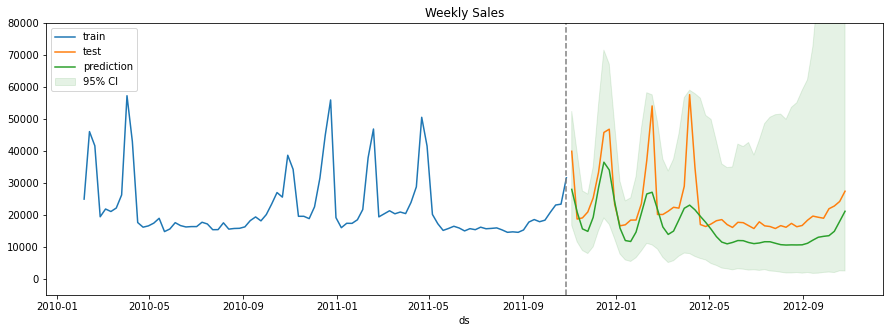

In [31]:
fig, ax = plt.subplots()
plt.rc('figure',figsize=(20,5))

sns.lineplot(x='Date', y='Weekly_Sales', label='train', data=sales_s1d1_df_train, ax=ax)
sns.lineplot(x='Date', y='Weekly_Sales', label='test', data=sales_s1d1_df_test, ax=ax)
sns.lineplot(x='ds', y='exp_yhat', label='prediction', data=forecast_test, ax=ax)

# visualizing the confidence interval
ax.fill_between(
    x=forecast_test['ds'],
    y1=forecast_test['exp_yhat_lower'],
    y2=forecast_test['exp_yhat_upper'],
    color='green', 
    alpha=0.1,
    label='95% CI'
)

plt.ylim(-5000,80000)

ax.axvline(threshold_date, color='grey', linestyle='--')
ax.legend(loc='upper left')
ax.set(title='Weekly Sales', ylabel='');

We can see right away that our forecast is consistently underestimating the observations, even though the observations are all within the 95% confidence interval of predictions. Combined with the component plots below (log scale), we can also see that the model includes a decreasing trend, and there is a large amount of uncertainty in the trend component as time goes on and the confidence interval expands. Holidays, on the other hand, does not seem to affect sales in Store 1 Department 1.

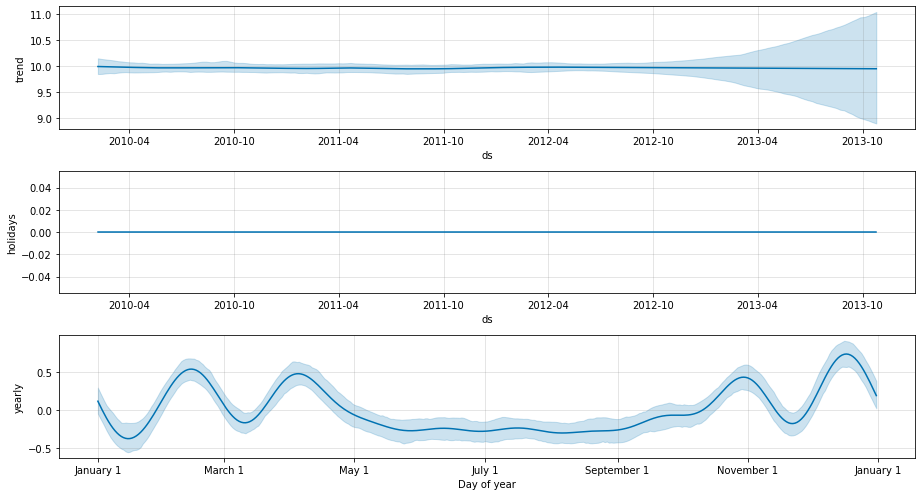

In [32]:
model.plot_components(forecast, figsize=(13,7));

### Residual Diagnosis

Residuals are the differences between predicted values and observed values (for a lot of models but not all), and they are useful in checking whether the model has captured an adequate amount of information from the data. In a good model, the residuals should be uncorrelated and have a mean that is close to 0: correlated residuals signal that there is information left in the errors that can be further modeled, whereas a mean far away from 0 means that the predictions are biased.

In [16]:
forecast_test['errors'] = forecast_test['exp_yhat']-sales_s1d1_df_test['Weekly_Sales']

# Information on the SettingWithCopywarning that might occur: 
# https://www.dataquest.io/blog/settingwithcopywarning/

errors_mean = forecast_test['errors'].mean()
errors_std = forecast_test['errors'].std()

print('Residual mean: {:.2f}'.format(errors_mean))
print('Residual standard deviation: {:.2f}'.format(errors_std))

Residual mean: -6369.44
Residual standard deviation: 5974.84


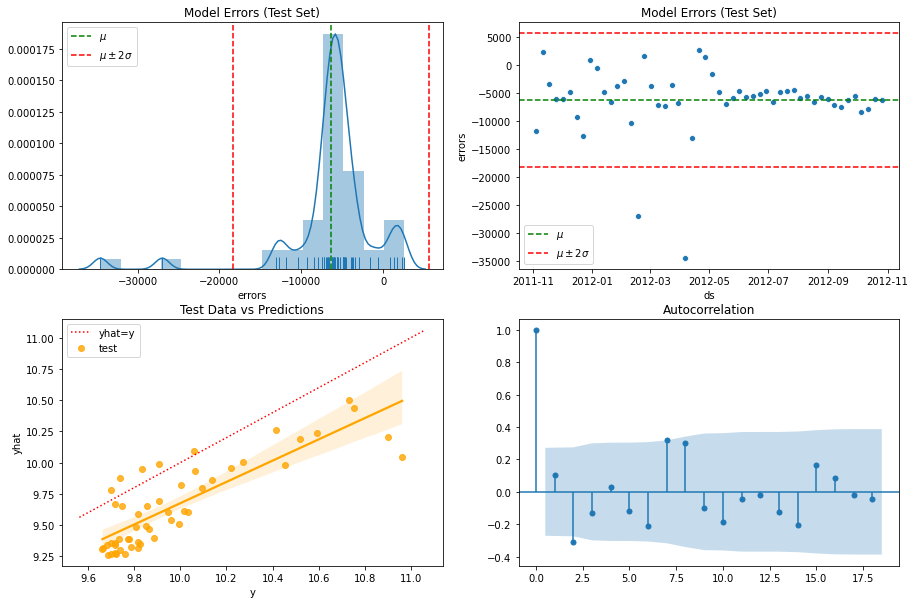

In [17]:
fig, axes = plt.subplots(2,2,figsize=(15,10))

# Plot residual distribution
sns.distplot(a=forecast_test['errors'], ax=axes[0,0], bins=15, rug=True)
axes[0,0].axvline(x=errors_mean, color='green', linestyle='--', label=r'$\mu$')
axes[0,0].axvline(x=errors_mean + 2*errors_std, color='red', linestyle='--', label=r'$\mu \pm 2\sigma$')
axes[0,0].axvline(x=errors_mean - 2*errors_std, color='red', linestyle='--')
axes[0,0].legend()
axes[0,0].set(title='Model Errors (Test Set)')

# Plot residuals against time
sns.scatterplot(x='ds', y='errors', data=forecast_test, ax=axes[0,1])
axes[0,1].axhline(y=errors_mean, color='green', linestyle='--', label=r'$\mu$ ')
axes[0,1].axhline(y=errors_mean + 2*errors_std, color='red', linestyle='--', label=r'$\mu \pm 2\sigma$')
axes[0,1].axhline(y=errors_mean - 2*errors_std, color='red', linestyle='--')
axes[0,1].legend()
axes[0,1].set(title='Model Errors (Test Set)')

# Plot prediction against observations
sns.regplot(x=sales_s1d1_test['y'], y=forecast_test['yhat'], color='orange', label='test', ax=axes[1,0])
# Generate diagonal line to plot.
d_x = np.linspace(start=sales_s1d1_test['y'].min()-0.1, stop=sales_s1d1_test['y'].max()+0.1, num=100)
axes[1,0].plot(d_x, d_x, color='red', label='yhat=y', ls=':')
axes[1,0].legend()
axes[1,0].set(title='Test Data vs Predictions')

# Plot autocorrelation of residuals
plot_acf(x=forecast_test['errors'], ax=axes[1,1])

plt.show()

In [20]:
# Calculate key error metrics
mean_abs_err = np.mean(abs(forecast_test['errors']))
mean_sqrd_err = np.mean(np.square(forecast_test['errors']))
rt_mean_sqrd_err = np.sqrt(mean_sqrd_err)
mean_abs_pct_err = np.mean(abs(forecast_test['errors']/sales_s1d1_test['y']))

display(pd.DataFrame({'MAE': mean_abs_err,
                      'MSE': mean_sqrd_err,
                      'RMSE': rt_mean_sqrd_err,
                      'MAPE': mean_abs_pct_err}, index=['Measurements']))

,MAE,MSE,RMSE,MAPE
Measurements,6698.44868,7.558195e+07,8693.788244,659.131386


We can see that the mean of our residuals is smaller than 0, and our predictions were frequently underestimation of the observed data. The distribution of the residuals is skewed by some extremely negative forecasting errors (underestimation) as well. The plots above also show that the variance of our residuals is *not* constant overtime&mdash;it decreases from the beginning to the end of the year. Luckily, there is not much significant auto correlation in the residuals. In short, our forecast is very biased, but there is not really much more information or pattern that is not captured in our model. However, this is not to say that we cannot find a better model (*or more importantly, collect more data*). In our case, we make use of the Prophet package as it is compatible with weekly data; there are perhaps other parameters that we can fine tune, or potentially other models that should be fitted to our data, before we make the final decision on which model to use. For the sake of simplicity, we will go ahead with this model and forecast future sales.

## Forecasting

---

Now that we have an understanding of the prediction errors of our model, we can move on to build a full model using all the existing data. Please be careful not to test the model with data that are used to create the model.

In [22]:
sales_s1d1 = (sales_s1d1_df[['Date', 'Log_Weekly_Sales']]
              .rename(columns={'Date':'ds', 'Log_Weekly_Sales': 'y'}))

display(sales_s1d1.tail())

,ds,y
138,2012-09-28,9.849444
139,2012-10-05,9.994446
140,2012-10-12,10.032936
141,2012-10-19,10.093499
142,2012-10-26,10.217963


In [29]:
model = Prophet(yearly_seasonality=True, 
                weekly_seasonality=False, 
                daily_seasonality=False, 
                holidays=holidays_s1d1, 
                interval_width=0.95, 
                mcmc_samples=100)

model.fit(sales_s1d1)

# Extend dates and features. 
future = model.make_future_dataframe(periods=sales_s1d1_test.shape[0], freq='7D')
# Generate predictions. 
forecast = model.predict(df=future)

# Back-transform the predictions and confidence intervals
forecast.loc[:,'exp_yhat'] = np.exp(forecast.loc[:,'yhat'])
forecast.loc[:,'exp_yhat_upper'] = np.exp(forecast.loc[:,'yhat_upper'])
forecast.loc[:,'exp_yhat_lower'] = np.exp(forecast.loc[:,'yhat_lower'])

display(forecast.tail())
# Scroll to the right for back-transformed forecasts

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holiday,...,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,exp_yhat,exp_yhat_upper,exp_yhat_lower
190,2013-09-27,9.949436,8.878983,10.863036,9.005251,10.931574,-0.069406,-0.220070,0.083404,0.0,...,-0.069406,-0.220070,0.083404,0.0,0.0,0.0,9.880030,19536.299549,52210.357567,7179.482755
191,2013-10-04,9.949049,8.864927,10.906662,8.981442,10.937505,-0.066797,-0.223274,0.063376,0.0,...,-0.066797,-0.223274,0.063376,0.0,0.0,0.0,9.882252,19579.767680,54538.503668,7079.277725
192,2013-10-11,9.948662,8.951491,11.034013,8.958226,10.964481,0.002060,-0.148902,0.136651,0.0,...,0.002060,-0.148902,0.136651,0.0,0.0,0.0,9.950722,20967.349025,61945.667035,7719.392897
193,2013-10-18,9.948275,9.034649,11.254050,8.927615,10.999212,0.180019,0.032323,0.300479,0.0,...,0.180019,0.032323,0.300479,0.0,0.0,0.0,10.128293,25041.585266,77191.909834,8388.771142
194,2013-10-25,9.947888,9.218415,11.475638,8.902477,11.033823,0.376329,0.228094,0.506146,0.0,...,0.376329,0.228094,0.506146,0.0,0.0,0.0,10.324217,30461.435565,96339.867815,10081.072583


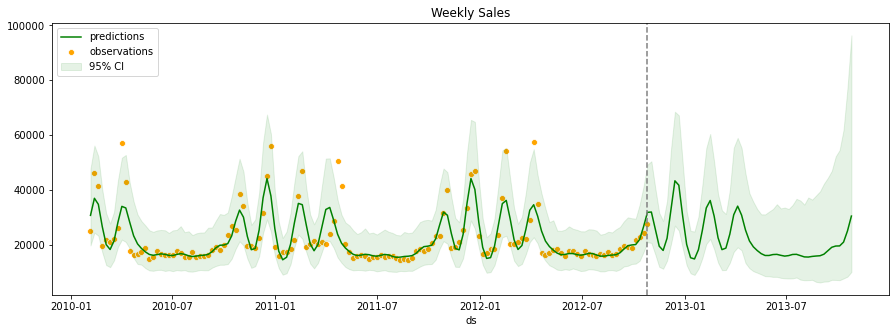

In [34]:
fig, ax = plt.subplots()
plt.rc('figure',figsize=(15,7))

sns.scatterplot(x='Date', y='Weekly_Sales', label='observations', color='orange', data=sales_s1d1_df, ax=ax)
sns.lineplot(x='ds', y='exp_yhat', label='predictions', color='green', data=forecast, ax=ax)

# visualizing the confidence interval
ax.fill_between(
    x=forecast['ds'],
    y1=forecast['exp_yhat_lower'],
    y2=forecast['exp_yhat_upper'],
    color='green', 
    alpha=0.1,
    label='95% CI'
)

# plt.ylim(-5000,80000)

ax.axvline(max(sales_s1d1_df['Date']), color='grey', linestyle='--')
ax.legend(loc='upper left')
ax.set(title='Weekly Sales', ylabel='');

## Next Steps

---

Now that you have a basic understanding of our data as well as forecasting for a single time series in Python using `Prophet`, we encourage you to:

1. Read through the [documentation for Prophet](https://facebook.github.io/prophet/docs/quick_start.html) and fine tune any additional parameters that you think could improve our model
2. Create your own Prophet model, with a different dataset (try to find a time series that is much longer than what we used in this notebook)
3. Come up with a strategy to efficiently forecast for multiple stores and departments